# Result reproduction

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

#np.random.seed(32)

from MyDataset import IndianPines, PaviaUniversity, PaviaCenter
from SSGA import SSGA

In [16]:
usedDataset = IndianPines
#usedDataset = PaviaUniversity
#usedDataset = PaviaCenter

145 145 200
178


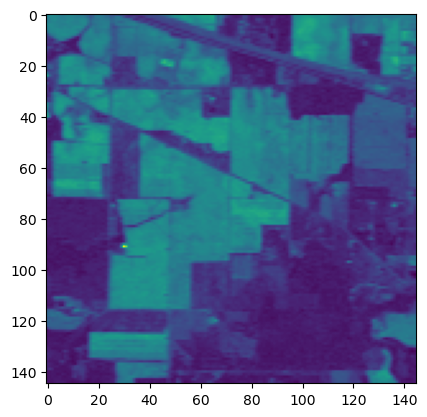

In [17]:
n,m,B = usedDataset["shape"]
print(n,m,B)
b = np.random.randint(0, B-1)
print(b)
plt.imshow(usedDataset["data"][:,:,b])
plt.show()

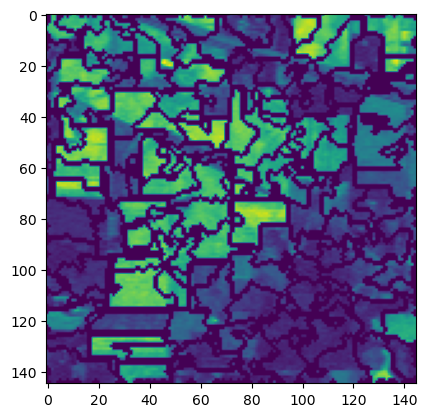

In [18]:
from EntropyRateSuperpixel import find_superpixel, complete_basic_similarity, create_img_with_borders

K = 300
SP = find_superpixel(usedDataset["data"], K, 0.5*8, complete_basic_similarity, True)
SP_img = create_img_with_borders(usedDataset["data"][:,:,b], SP)
plt.imshow(SP_img)
plt.show()

0.7369445351435785
0.7397017185351611
0.7378057743066565
0.7505516364908058
0.7367068948288454
0.7404903800644631
0.7553048964460533
0.7397928005204569
0.7328347376647071
0.7430538985712009


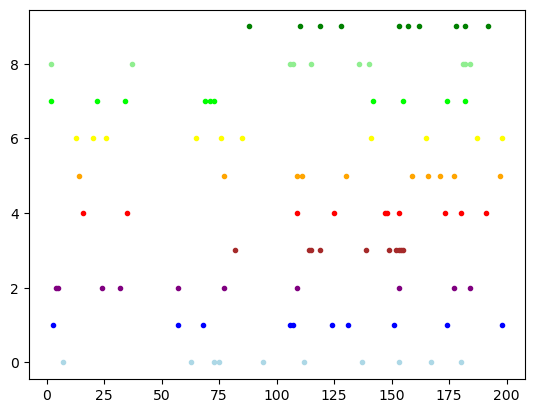

In [19]:
class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1

N = 10
colors = ["lightblue", "blue", "purple", "brown", "red", "orange", "yellow", "lime", "lightgreen", "green"]
best_indiv = None
best_fitness = 0
for j in range(N):
    pop, fitness = SSGA(usedDataset["data"], 10, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2, False, SP=SP)
    if fitness[0]>best_fitness:
        best_indiv = pop[0]
        best_fitness = fitness[0]
    print(fitness[0])
    for i,b in enumerate(pop[0]):
        if b==1:
            plt.plot(i,j, ".", color=colors[j])
plt.show()

# Select samples

In [26]:
import sklearn.utils

def split_data(dataset, percent, bands):
    for_slices = [i for i in range(len(bands)) if bands[i]==1]
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    nb_info = sum([len(liste) for key,(_,liste) in dataset["class"].items() if key!=0])
    weights = {}
    for key, (name, liste) in dataset["class"].items():
        if key !=0:
            indices = np.zeros(len(liste), dtype=int)
            indices[:int(len(liste)*percent)] = 1
            weights[key] = nb_info/ len(liste)
            print(key, name, int(len(liste)*percent), len(liste), len(liste)/nb_info)
            
            for i in range(len(liste)):
                data = dataset["data"][liste[i]]
                if indices[i]==1:
                    X_train.append(data[for_slices])
                    y_train.append(key)
                else:
                    X_test.append(data[for_slices])
                    y_test.append(key)

    X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)
    X_test, y_test = sklearn.utils.shuffle(X_test, y_test, random_state=42)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), weights
   
    

best_paper_indiv = [0 for _ in range(B)]
indian_best_index = [16, 28, 31, 38, 71, 83, 113, 128, 162]
university_best_index = [18, 33, 47, 64, 69, 72, 67, 83, 85]
center_best_index = [16, 37, 44, 66, 74, 83, 85, 97, 101]
for i in university_best_index:
    best_paper_indiv[i] = 1

from SSGA import fitness_function, compute_Sbsp_Stsp_list
#Sbsp_list, Stsp_list = compute_Sbsp_Stsp_list(usedDataset["data"], SP)
#print(fitness_function(best_paper_indiv, Sbsp_list, Stsp_list))



bands=best_indiv
#bands=best_paper_indiv
#bands=[1 for _ in range(B)]
X_train,y_train, X_test,y_test, weights = split_data(usedDataset, 0.05, bands)
print(X_train.shape, X_test.shape)
print(weights)

1 Alfalfa 2 46 0.00448824275539077
2 Corn-notill 71 1428 0.13933066640647868
3 Corn-mintill 41 830 0.08098351058639867
4 Corn 11 237 0.023124207239730705
5 Grass-pasture 24 483 0.047126548931603084
6 Grass-trees 36 730 0.07122646111815786
7 Grass-pasture-mowed 1 28 0.002731973851107425
8 Hay-windrowed 23 478 0.04663869645819104
9 Oats 1 20 0.0019514098936481608
10 Soybean-notill 48 972 0.09483852083130062
11 Soybean-mintill 122 2455 0.23953556444531174
12 Soybean-clean 29 593 0.057859303346667966
13 Wheat 10 205 0.020001951409893647
14 Woods 63 1265 0.12342667577324618
15 Buildings-Grass-Trees-Drives 19 386 0.03766221094740951
16 Stone-Steel-Towers 4 93 0.009074056005463947
(505, 10) (9744, 10)
{1: 222.80434782608697, 2: 7.177170868347339, 3: 12.348192771084337, 4: 43.244725738396625, 5: 21.21946169772257, 6: 14.03972602739726, 7: 366.0357142857143, 8: 21.44142259414226, 9: 512.45, 10: 10.544238683127572, 11: 4.174745417515275, 12: 17.283305227655987, 13: 49.99512195121951, 14: 8.10197

# Sklearn SVM

In [27]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scalar', StandardScaler()),
    ('svc', svm.SVC(kernel='rbf'))
])

param_grid = {
    'svc__C': [0.1, 1, 10, 100, 1000, 2000, 4000],
    'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001],

    #'svc__C': [10, 50, 75, 100, 150],
    #'svc__gamma': [1, 0.75, 0.5, 0.25, 0.01]
}

clf = svm.SVC(kernel="rbf", C=1.0, gamma="scale")#, class_weight="balanced")
#clf = svm.SVC(kernel="rbf", C=2**32, gamma=3.0517578125e-05)#, class_weight="balanced")
clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(y_pred.tolist())
print("Accuracy =", len([0 for i in range(len(y_pred)) if y_pred[i]==y_test[i]])/len(y_pred))

print(clf.get_params())
print(clf.best_estimator_.get_params())

/usr/lib/python3/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[12, 11, 14, 10, 4, 14, 14, 11, 3, 11, 2, 3, 12, 10, 10, 5, 13, 12, 11, 5, 4, 4, 12, 12, 11, 11, 4, 4, 11, 2, 12, 11, 11, 14, 12, 11, 2, 11, 5, 10, 12, 15, 11, 11, 10, 14, 11, 1, 2, 15, 6, 4, 14, 14, 3, 11, 11, 11, 15, 2, 3, 8, 11, 15, 11, 5, 11, 6, 11, 14, 8, 5, 3, 1, 14, 15, 8, 11, 4, 2, 3, 2, 12, 11, 11, 2, 11, 4, 3, 15, 14, 12, 3, 2, 5, 10, 6, 15, 16, 14, 4, 11, 2, 3, 11, 2, 10, 4, 12, 4, 3, 11, 14, 3, 7, 11, 2, 2, 6, 3, 11, 14, 13, 14, 11, 4, 3, 2, 11, 5, 11, 2, 12, 2, 14, 4, 6, 2, 11, 14, 11, 15, 11, 10, 3, 3, 4, 6, 6, 12, 5, 3, 2, 12, 12, 5, 11, 7, 6, 2, 2, 3, 12, 11, 11, 13, 11, 15, 2, 11, 2, 11, 14, 11, 13, 11, 15, 2, 3, 2, 11, 2, 6, 14, 14, 14, 14, 11, 11, 6, 6, 2, 11, 2, 11, 2, 4, 11, 5, 2, 14, 2, 12, 8, 2, 4, 11, 15, 2, 4, 6, 11, 7, 11, 5, 6, 3, 11, 15, 2, 14, 15, 10, 11, 12, 4, 8, 3, 1, 7, 12, 3, 13, 14, 3, 2, 14, 2, 11, 6, 6, 6, 12, 2, 12, 2, 11, 11, 10, 12, 6, 3, 2, 11, 14, 8, 5, 11, 8, 12, 8, 6, 2, 14, 14, 11, 14, 11, 11, 14, 5, 3, 4, 10, 2, 14, 2, 2, 14, 2, 6, 4, 11, 1

# LibSVM1 toolbox

https://www.csie.ntu.edu.tw/~cjlin/libsvm/

In [28]:
from libsvm.svmutil import svm_train, svm_predict, svm_parameter, svm_problem
from sklearn.model_selection import KFold

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Prepare cross-validation splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Parameters grid
C_values = [0.1, 1, 10, 100]
gamma_values = [1, 0.1, 0.01, 0.001]

best_score = 0
best_params = {}

for C in C_values:
    for gamma in gamma_values:
        accuracies = []
        for train_index, val_index in kf.split(X_scaled):
            X_train_cv, X_val_cv = X_scaled[train_index], X_scaled[val_index]
            y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

            # Create libsvm problem
            prob = svm_problem(y_train_cv.tolist(), X_train_cv.tolist())

            # Setup parameters string for libsvm
            param_str = f'-s 0 -t 2 -c {C} -g {gamma} -q'  
            # -s 0: C-SVC, -t 2: RBF kernel, -c: C, -g: gamma, -q: quiet mode

            param = svm_parameter(param_str)

            # Train model
            model = svm_train(prob, param)

            # Predict on validation fold
            p_label, p_acc, p_val = svm_predict(y_val_cv.tolist(), X_val_cv.tolist(), model, options='-q')

            accuracies.append(p_acc[0])  # p_acc is [accuracy, mean squared error, squared correlation]

        avg_acc = np.mean(accuracies)
        print(f"C={C}, gamma={gamma}, CV accuracy={avg_acc:.4f}")

        if avg_acc > best_score:
            best_score = avg_acc
            best_params = {'C': C, 'gamma': gamma}

print(f"Best CV accuracy: {best_score:.4f} with params {best_params}")


C=0.1, gamma=1, CV accuracy=52.4752
C=0.1, gamma=0.1, CV accuracy=55.4455
C=0.1, gamma=0.01, CV accuracy=36.6337
C=0.1, gamma=0.001, CV accuracy=24.1584
C=1, gamma=1, CV accuracy=78.4158
C=1, gamma=0.1, CV accuracy=75.2475
C=1, gamma=0.01, CV accuracy=51.8812
C=1, gamma=0.001, CV accuracy=36.6337
C=10, gamma=1, CV accuracy=81.1881
C=10, gamma=0.1, CV accuracy=82.5743
C=10, gamma=0.01, CV accuracy=77.8218
C=10, gamma=0.001, CV accuracy=51.6832
C=100, gamma=1, CV accuracy=79.0099
C=100, gamma=0.1, CV accuracy=84.5545
C=100, gamma=0.01, CV accuracy=83.5644
C=100, gamma=0.001, CV accuracy=75.6436
Best CV accuracy: 84.5545 with params {'C': 100, 'gamma': 0.1}


In [29]:
from libsvm.svmutil import *
from libsvm.svm import *


prob = svm_problem(y_train, X_train)

# "parameters C and gamma were optimized by fivefold cross-validation"

param = svm_parameter()
param.kernel_type = 2 #RBF  # Radial Basis Function kernel
param.C = 2**0.1 #best_params["C"]  # Cost parameter
param.gamma = 1/(n*m * X_train.var()) #best_params["gamma"]  # Kernel parameter

#param.nr_weight = len(weights.keys())
#param.weight_label = (c_double * len(weights))(*list(weights.keys()))
#param.weight = (c_double * len(weights))(*list(weights.keys()))


# 5-fold cross-validation
param.cross_validation = True
param.nr_fold = 5
accuracy = svm_train(prob, param)

# Train model
param.cross_validation = False
model = svm_train(prob, param)
p_labels, p_acc, p_vals = svm_predict(y_test, X_test, model)  
print(p_labels)
print(p_acc)

*
optimization finished, #iter = 34
nu = 0.456693
obj = -61.677391, rho = 0.985223
nSV = 59, nBSV = 57
*
optimization finished, #iter = 16
nu = 0.711111
obj = -34.264671, rho = -0.997349
nSV = 32, nBSV = 32
*
optimization finished, #iter = 29
nu = 0.674419
obj = -61.681817, rho = 0.973965
nSV = 58, nBSV = 58
*
optimization finished, #iter = 29
nu = 0.935484
obj = -61.734545, rho = 0.977856
nSV = 58, nBSV = 58
*
optimization finished, #iter = 29
nu = 0.725000
obj = -62.046392, rho = 0.994920
nSV = 58, nBSV = 58
*
optimization finished, #iter = 20
nu = 0.816327
obj = -42.808247, rho = -0.994100
nSV = 40, nBSV = 40
*
optimization finished, #iter = 29
nu = 0.852941
obj = -61.868935, rho = 0.987895
nSV = 58, nBSV = 58
*
optimization finished, #iter = 10
nu = 0.473684
obj = -19.214204, rho = -0.990088
nSV = 18, nBSV = 18
*
optimization finished, #iter = 24
nu = 0.905660
obj = -51.173060, rho = -0.985721
nSV = 48, nBSV = 48
*
optimization finished, #iter = 19
nu = 0.791667
obj = -40.577907, r

In [30]:
def save_libsmv_data(path, X_train, y_train):
    f = open(path, "w")
    for i in range(len(y_train)):
        txt = str(y_train[i])
        for j in range(len(X_train[i])):
            txt += " " + str(j+1) + ":" + str(X_train[i,j])
        f.write(txt + "\n")
    f.close()

save_libsmv_data("libsvm_train_data.txt", X_train, y_train)
save_libsmv_data("libsvm_test_data.txt", X_test, y_test)

In [31]:
y_train_libsvm, X_train_svm = svm_read_problem('libsvm_train_data.txt')
y_test_libsvm, X_test_libsvm = svm_read_problem("libsvm_test_data.txt")
# Train the model (C-SVC with RBF kernel by default)
c=32.0
g=3.0517578125e-05
print('-c {} -g {}'.format(c,g))
model = svm_train(y_train_libsvm, X_train_svm, '-c {} -g {} '.format(c,g))

# Predict using the same training data (or test data)
p_label, p_acc, p_val = svm_predict(y_test_libsvm, X_test_libsvm, model)
print(p_label)

-c 32.0 -g 3.0517578125e-05
*
optimization finished, #iter = 40
nu = 0.455696
obj = -2292.386597, rho = 0.990298
nSV = 72, nBSV = 72
*
optimization finished, #iter = 19
nu = 0.690909
obj = -1215.353210, rho = -0.998311
nSV = 38, nBSV = 38
*
optimization finished, #iter = 36
nu = 0.672897
obj = -2292.045471, rho = 0.981884
nSV = 72, nBSV = 72
*
optimization finished, #iter = 36
nu = 0.935065
obj = -2293.549866, rho = 0.985412
nSV = 72, nBSV = 72
*
optimization finished, #iter = 36
nu = 0.727273
obj = -2301.057373, rho = 0.996739
nSV = 72, nBSV = 72
*
optimization finished, #iter = 24
nu = 0.800000
obj = -1534.363953, rho = -0.995738
nSV = 48, nBSV = 48
*
optimization finished, #iter = 36
nu = 0.857143
obj = -2296.776245, rho = 0.992054
nSV = 72, nBSV = 72
*
optimization finished, #iter = 11
nu = 0.468085
obj = -702.093262, rho = -0.993455
nSV = 22, nBSV = 22
*
optimization finished, #iter = 29
nu = 0.892308
obj = -1849.869934, rho = -0.991182
nSV = 58, nBSV = 58
*
optimization finished,